In [1]:
print('hi')

hi


In [3]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
# Path to your CSVs
path = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index/1.5Y-old-tokens/dataframes/*.csv"
csv_files = glob.glob(path)

print(f"Found {len(csv_files)} CSV files.\n")

# Print filename and number of rows
for file in csv_files:
    try:
        df = pd.read_csv(file)
        token = os.path.basename(file).replace(".csv", "")
        print(f"{token}: {df.shape[0]} rows")
    except Exception as e:
        print(f"Failed to read {file}: {e}")

Found 9 CSV files.

KEKEC: 364 rows
JOE: 375 rows
BCAT: 369 rows
LMI: 347 rows
EMP: 360 rows
TITANX: 353 rows
ZYN: 368 rows
SATOSHI: 372 rows
SPECTRE: 360 rows


Found 9 valid tokens: ['KEKEC', 'JOE', 'BCAT', 'LMI', 'EMP', 'TITANX', 'ZYN', 'SATOSHI', 'SPECTRE']


<Figure size 1200x800 with 0 Axes>

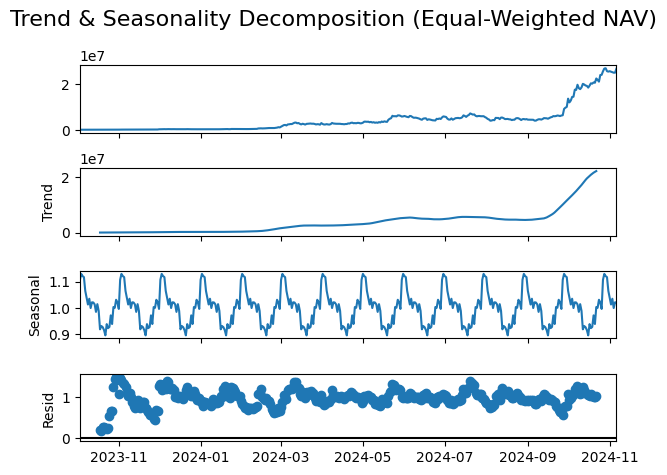

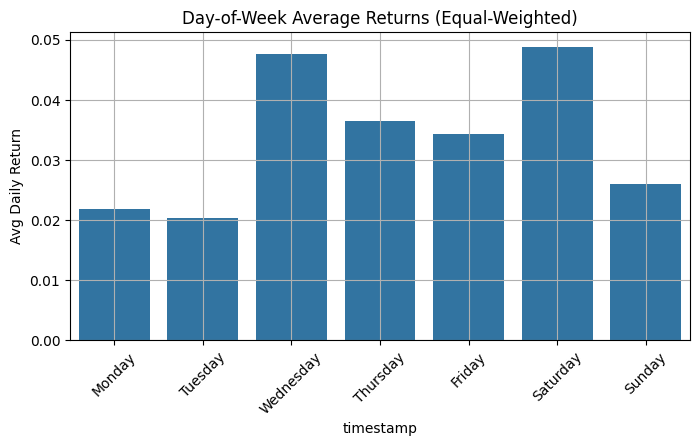

/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_89155/3615199747.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sum = monthly_returns.resample('M').sum()


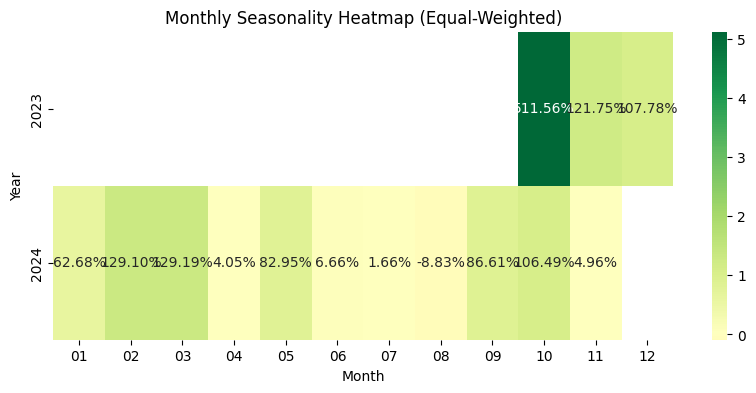

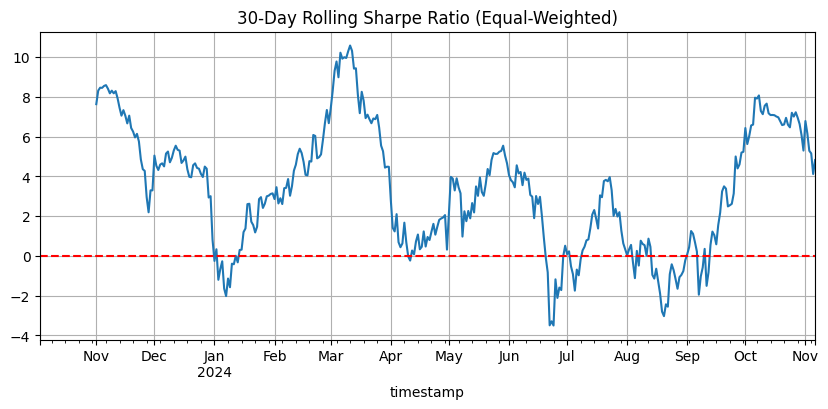

In [5]:
# === 1. Load CSVs ===
path = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index/1.5Y-old-tokens/dataframes/*.csv"
csv_files = glob.glob(path)

dfs = {}
for file in csv_files:
    token = os.path.basename(file).replace(".csv", "")
    df = pd.read_csv(file, parse_dates=["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)
    df = df[df["close"] > 0]
    if len(df) >= 345:
        df = df.iloc[:345].copy()
        df["token"] = token
        dfs[token] = df

print(f"Found {len(dfs)} valid tokens: {list(dfs.keys())}")

# === 2. Pivot ===
merged = pd.concat(dfs.values())
pivot_close = merged.pivot(index="timestamp", columns="token", values="close")
pivot_volume = merged.pivot(index="timestamp", columns="token", values="volume")

# Filter tokens with full data
valid_tokens = pivot_close.columns[pivot_close.notna().sum() == 345]
pivot_close = pivot_close[valid_tokens].ffill().bfill()
pivot_volume = pivot_volume[valid_tokens].ffill().bfill()

# === 3. Create Daily Portfolio NAV ===
daily_returns = pivot_close.pct_change().dropna()
vol_weights = pivot_volume.iloc[0] / pivot_volume.iloc[0].sum()
eq_weights = np.repeat(1 / len(valid_tokens), len(valid_tokens))

eq_port_ret = daily_returns.dot(eq_weights)
vol_port_ret = daily_returns.dot(vol_weights)

eq_nav = (1 + eq_port_ret).cumprod() * 1000
vol_nav = (1 + vol_port_ret).cumprod() * 1000

# === 4. Trend Decomposition ===
# Use equal-weighted for trend analysis
decomp = seasonal_decompose(eq_nav, model="multiplicative", period=30)

plt.figure(figsize=(12, 8))
decomp.plot()
plt.suptitle("Trend & Seasonality Decomposition (Equal-Weighted NAV)", fontsize=16)
plt.tight_layout()
plt.show()

# === 5. Day-of-Week Returns ===
dow_returns = eq_port_ret.copy()
dow_returns.index = dow_returns.index.day_name()
dow_avg = dow_returns.groupby(dow_returns.index).mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(8, 4))
sns.barplot(x=dow_avg.index, y=dow_avg.values)
plt.title("Day-of-Week Average Returns (Equal-Weighted)")
plt.ylabel("Avg Daily Return")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# === 6. Monthly Seasonality Heatmap ===
monthly_returns = eq_port_ret.copy()
monthly_returns.index = pd.to_datetime(monthly_returns.index)
monthly_sum = monthly_returns.resample('M').sum()
monthly_sum.index = monthly_sum.index.strftime('%Y-%m')
month_table = pd.DataFrame({
    "Month": [i[5:] for i in monthly_sum.index],
    "Year": [i[:4] for i in monthly_sum.index],
    "Return": monthly_sum.values
})
heatmap = month_table.pivot(index="Year", columns="Month", values="Return")

plt.figure(figsize=(10, 4))
sns.heatmap(heatmap, annot=True, fmt=".2%", cmap="RdYlGn", center=0)
plt.title("Monthly Seasonality Heatmap (Equal-Weighted)")
plt.show()

# === 7. Rolling Sharpe Ratio ===
rolling_sharpe = eq_port_ret.rolling(30).mean() / eq_port_ret.rolling(30).std() * np.sqrt(252)

plt.figure(figsize=(10, 4))
rolling_sharpe.plot()
plt.title("30-Day Rolling Sharpe Ratio (Equal-Weighted)")
plt.axhline(0, color='red', linestyle='--')
plt.grid()
plt.show()
